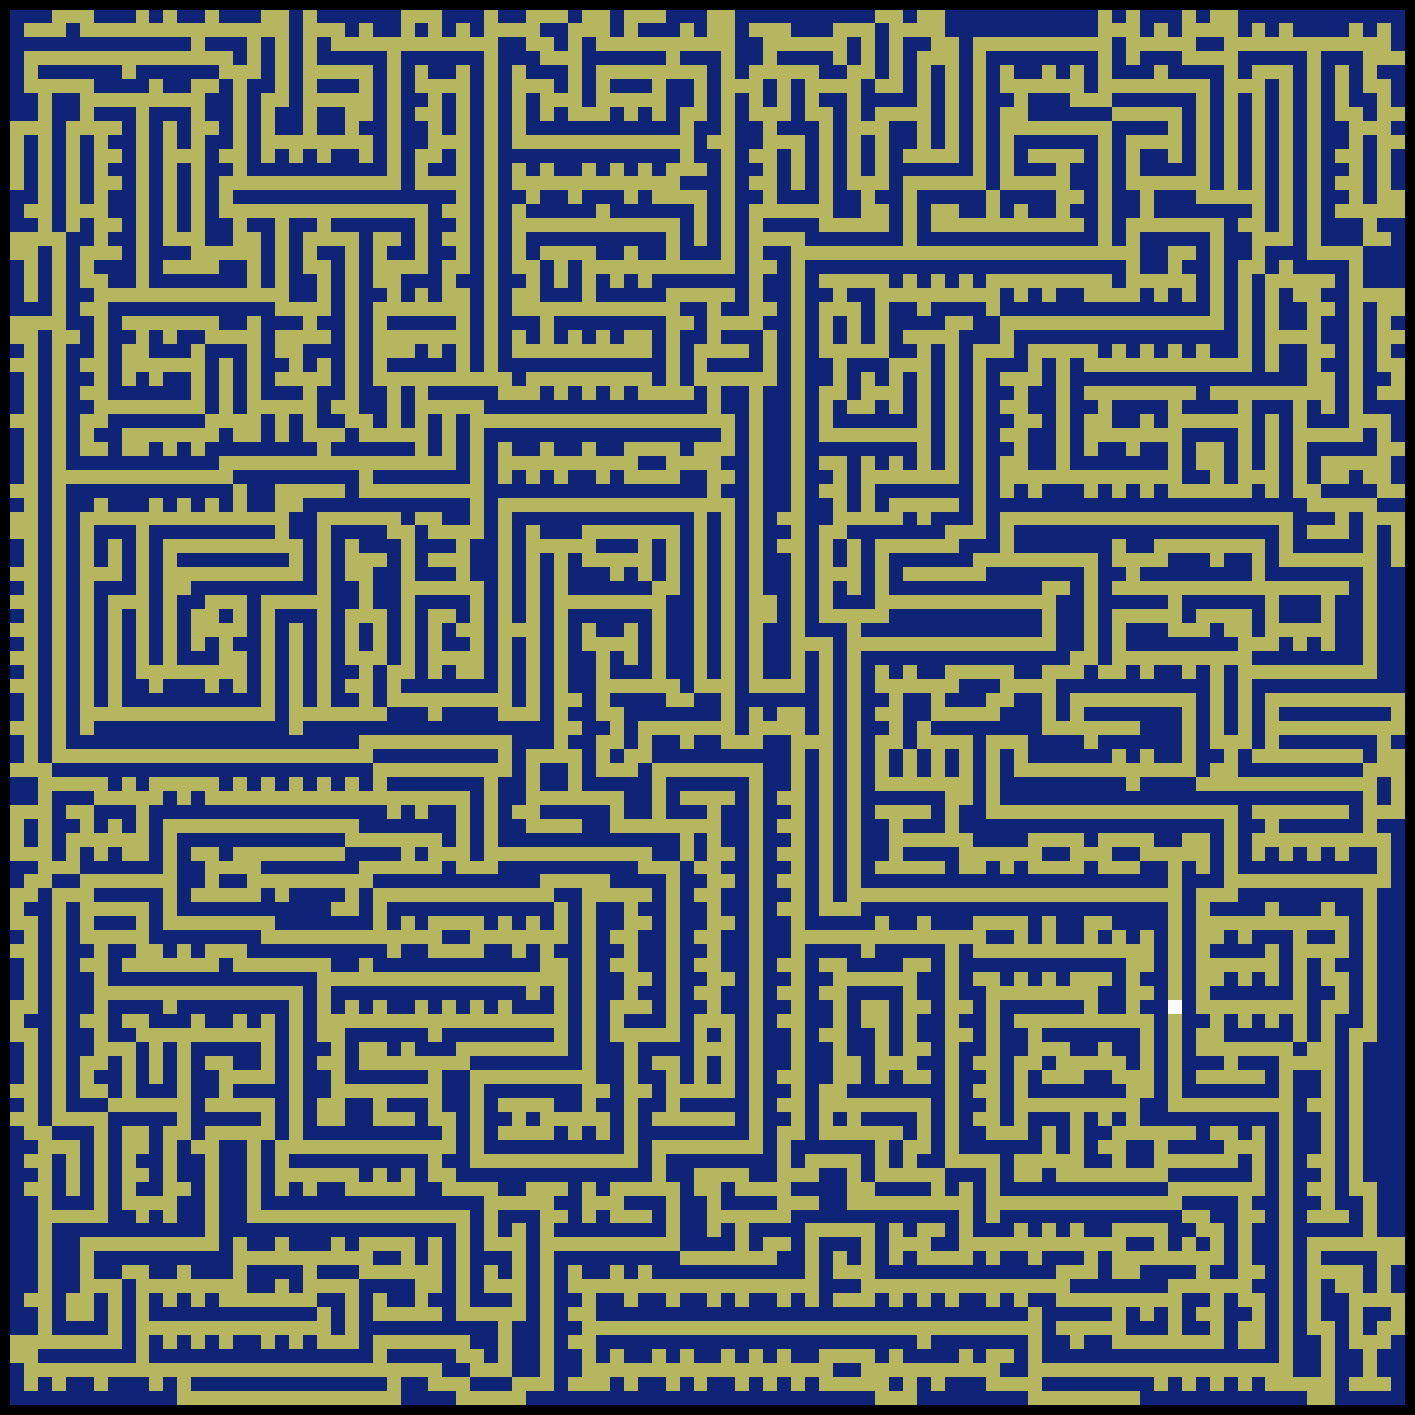

In [2]:
# funções usando Cython
from especial import vizinhos_especial, vizinhos_invertidos_especial, vizinhos_ordenados, densidade_local_especial, quant_viz_expand_especial
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time

class RLabirinto:

    def __init__(
            self, m, n, 
            labirinto = None, 
            metodo = 'expandir', 
            salvar = False, 
            detalhes = False, 
            pixelado = False, 
            seed = None,
            paleta = 'gist_earth'):
        '''
        Cria um labirinto, subconjunto de uma matriz mxn majoritariamente de 0's e 1's.
        Passe uma matriz (numpy array 2D int8) de labirinto pronta no argumento labirinto.
        Se método=='expandir', inicia uma matriz mxn vazia e adiciona os quadrados do labirinto.
        Se método=='destruir', inicia uma matriz mxn de 1's e retira quadrados.
        'salvar' salva um gif numa subpasta 'Labirintos', mas não a cria automaticamente, crie-a.
        'detalhes' é o famoso 'verbose', printa algumas informações durante o processo.
        '''

        global printd
        if detalhes:
            def printd(*_): print(*_)
        else:
            def printd(*_): pass
        self.shape = (m, n)
        self.tamanho = int(0.5*m*n)
        if seed is None:
            self.seed = np.random.randint(1000000)
        else:
            self.seed = seed
        self.rng = random.Random(self.seed)  # np.random.default_rng(self.seed)
        self.saida = (self.rng.randrange(m), self.rng.randrange(n))
        self.salvar = salvar
        self.local = None
        self.ax = 0
        self.pixelado = pixelado
        self.paleta = paleta
        if labirinto:
            self.labirinto = labirinto
            if input('Deseja colocar saída?') == 'sim':
                self.saida = (input('Insira coordenadas x,y:'))
            printd('Saída do labirinto:', self.saida)
        else:
            printd('Saída do labirinto:', self.saida)
            if metodo == 'destruir':
                self.labirinto = np.ones(self.shape, dtype=np.int8)
                self.gerar_labirinto(metodo)
            elif metodo == 'expandir':
                self.labirinto = np.zeros(self.shape, dtype=np.int8)
                self.gerar_labirinto(metodo)
            else:
                raise Exception(
                    'Erro ao gerar labirinto, escolha um método adequado')

    def gerar_labirinto(self, metodo):
        if self.salvar:
            local = os.path.join(
                'Labirintos', 
                'Labirinto{:02d}'.format(1+len(os.listdir('Labirintos')))
                )
            os.mkdir(local)
            self.local = os.path.join(local,'frame')

        if metodo == 'destruir':
            self.polir(primeiro=True)

        elif metodo == 'expandir':
            self.labirinto[self.saida[0], self.saida[1]] = 1
            casas = [(self.saida[0], self.saida[1])]
            self.expansao(casas, N=self.tamanho)
            self.polir(pouco=True)
            printd('casas:', self.tamanho)
        else:
            raise Exception('Erro ao gerar labirinto, cheque o método usado.')
        if self.salvar:
            self.salvar_gif()

    def expansao(self, casas, N=0):
        tempo = time.perf_counter()
        frame_save = int(2**(-2+2*np.log10(self.shape[0]*self.shape[1])))
        if not N:
            N = self.tamanho
        falhas = 1
        f = -1
        tempo_choice, count = 0, 0
        t = 0.6  # threshold
        frequencia = 8*sum(self.shape)  # 8*m*n
        soma = np.sum(self.labirinto)  # quantas casas são 1?
        tempo_total = time.perf_counter()
        while soma != N:
            if not soma % (frequencia):
                casas.sort(key=lambda v: densidade_local_especial(
                    self.labirinto, v[0], v[1]), reverse=True)
            if f == 0 and self.salvar:
                count += 1
                if not count % frame_save:
                    self.salvar_fig()
            else: falhas += f
            if not self.salvar and (time.perf_counter() - tempo) > 360:
                printd('Tempo excedido, deveria ter ',
                       N, 'casas, mas tem', soma)
                break
            start3 = time.perf_counter()
            try:
                add_x, add_y = casas[-1]
            except:
                self.polir(pouco=True)
                casas = list(map(tuple, np.argwhere(
                    self.labirinto == 1).astype(int)))
                teste = []
                for casa in casas:
                    quant = len(
                        vizinhos_invertidos_especial(self.labirinto, casa[0], casa[1])
                        )
                    if quant >= 2:
                        teste.append(casa)
                casas = teste
                del teste
                if not casas:
                    printd('Expansão parou mais cedo (provavelmente por encher a matriz)')
                    break
                add_x, add_y = casas[-1]
                pass
            tempo_choice += time.perf_counter() - start3
            vizinhos = vizinhos_invertidos_especial(self.labirinto, add_x, add_y)
            viz = len(vizinhos)
            viz_expand = quant_viz_expand_especial(self.labirinto, add_x, add_y)
            f = 1
            p = self.rng.random()
            if (viz < 2) or viz_expand >= 5:
                casas.pop()
            elif (p <= t)*(viz >= 3) + (p > t)*(viz >= 2) + ((add_x, add_y) == self.saida)*(viz > 0):
                vizinhos.sort(
                    key=lambda v: densidade_local_especial(self.labirinto, v[0], v[1])
                    )
                v = vizinhos[ 0 if p <= 0.9 else 1 if p <= 0.97 else -1 ]
                tam = len(
                    vizinhos_invertidos_especial(self.labirinto, v[0], v[1])
                    )
                tam_expand = quant_viz_expand_especial(self.labirinto, v[0], v[1])
                f = 0
                if tam_expand < 4:
                    self.labirinto[v] = 1
                    soma += 1
                    if tam >= 2:
                        # mudar a posição do insert aqui altera o labirinto (append = insert(-1, .))
                        casas.append(v)
                elif viz >= 2:
                    casas.pop()

                if viz < 2:
                    casas.pop()

        printd('casas(interno):', len(casas), 'casas atuais:', soma)
        tempo_total = time.perf_counter() - tempo_total
        printd('falhas:', falhas, 'com threshold', t)
        printd(tempo_total)

    def polir(self, pouco=False, primeiro=False):
        frame_save = int(2**(-1 + 2*np.log10(self.shape[0]*self.shape[1])))
        if primeiro and not self.salvar:
            index = np.array([(x, y) for x in range(1, self.shape[0]-1, 2)
                             for y in range(1, self.shape[1]-1, 2)])
            self.labirinto[index[:, 0], index[:, 1]] = 0
            del index
            casas = list(map(tuple, np.argwhere(self.labirinto).astype(int)))
            remover = set()
        else:
            casas = list(map(tuple, np.argwhere(self.labirinto).astype(int)))
            remover = set()
            count = 0
            for quant in [8, 7]:  # tirando com 8 e 7 vizinhos
                for elemento in casas:
                    if quant_viz_expand_especial(self.labirinto, elemento[0], elemento[1]) == quant:
                        self.labirinto[elemento[0], elemento[1]] = 0
                        count += 1
                        if (not count % frame_save) and self.salvar:
                            self.salvar_fig()
                        remover.add((elemento[0], elemento[1]))

        if not pouco:  # tirando com 6 vizinhos
            printd('primeira polida completa')
            casas = list(set(casas).difference(remover))
            del remover
            self.rng.shuffle(casas)
            tempo_caminho, n, m, count = 0, 0, 0, 0
            falhas = 1
            f = -1
            tempo_caminho = 0
            quant = [6, 5, 4, 2]

            for elemento in casas:
                if f == 0 and self.salvar:
                    count += 1
                    if not count % frame_save:
                        self.salvar_fig()
                else: falhas += f
                f = 0
                if quant_viz_expand_especial(self.labirinto, elemento[0], elemento[1]) in quant:
                    self.labirinto[elemento] = 0
                    n += 1
                    m += 1
                    if not m % 100:
                        printd(m, '/', len(casas))
                        printd(f'\"falhas\" até agora: {falhas}')
                    vizinhos = vizinhos_especial(
                        self.labirinto, elemento[0], elemento[1])
                    try:
                        v = vizinhos[0]
                    except:
                        self.labirinto[elemento] = -1
                        self.salvar_fig()
                        raise Exception
                    memo = set([v])  
                    xove = time.perf_counter()
                    start1 = time.perf_counter()
                    if not self.caminho(v, memo, start=start1,
                                        primeiro=elemento,
                                        vizinhos=vizinhos,
                                        temporizador=True):
                        f = 1
                        n -= 1
                        self.labirinto[elemento] = 1
                    tempo_caminho += (time.perf_counter() - xove)

            printd(falhas, 'falhas no polimento')
            printd(tempo_caminho, 'para fazer os caminhos')
            if f == 0 and self.salvar:
                self.salvar_fig()

        self.tamanho = np.sum(self.labirinto)

    def caminho(self, v, memo, start, primeiro, vizinhos, temporizador=False, threshold=0.00025):
        if v in vizinhos:
            vizinhos.remove(v)
            if not vizinhos:
                return True
        if temporizador and (time.perf_counter() - start > threshold):
            return False
        viz, tam = vizinhos_ordenados(self.labirinto, v[0], v[1], primeiro[0], primeiro[1])
        if not tam:
            return False
        if tam == 1:
            vizinho = viz[0]
            del viz
            if vizinho not in memo:
                memo.add(vizinho)
                if self.caminho(vizinho, memo, start, primeiro, vizinhos, temporizador=temporizador, threshold=threshold):
                    return True
        else:
            vizinho1, vizinho2 = viz[0], viz[1]
            del viz
            if vizinho1 not in memo:
                memo.add(vizinho1)
                if self.caminho(vizinho1, memo, start, primeiro, vizinhos, temporizador=temporizador, threshold=threshold):
                    return True
            if vizinho2 not in memo:
                memo.add(vizinho2)
                if self.caminho(vizinho2, memo, start, primeiro, vizinhos, temporizador=temporizador, threshold=threshold):
                    return True

    def mostrar(self, tamanho=100):
        if self.pixelado:
            self.labirinto[self.saida[0], self.saida[1]] = 2
            fig, axe = plt.subplots(1, 1, figsize=(
                tamanho/100*9*np.log10(self.shape[0]), tamanho/100*9*np.log(self.shape[1])
                ), facecolor='black')
            axe.matshow(self.labirinto, cmap=self.paleta, vmin=-0.15, vmax=1.5)
            # axe.hlines(np.array(range(self.shape[0]))-0.5,xmin = -0.5, xmax = self.shape[1]-0.5, color='black', linewidth = 0.2)
            # axe.vlines(np.array(range(self.shape[1]))-0.5,ymin = -0.5, ymax = self.shape[0]-0.5, color='black', linewidth = 0.2)
            axe.set_axis_off()
            plt.show()
            self.labirinto[self.saida[0], self.saida[1]] = 1
            return fig
        else:
            import PIL
            from scipy.ndimage import zoom
            self.labirinto[self.saida[0], self.saida[1]] = 3
            _cm = plt.get_cmap(self.paleta)
            _norm = matplotlib.colors.Normalize(vmin=-0.15, vmax=1.5)
            img = PIL.Image.fromarray((_cm(_norm(zoom(self.labirinto, 10, order=2)))[
                                      :, :, :3]*255).astype(np.uint8))
            display(img)
            self.labirinto[self.saida[0], self.saida[1]] = 1
            return img

    def _fazer_fig(self, fname, formato):
        if self.ax == 0:
            fig = matplotlib.figure.Figure(figsize=(
                5*np.log10(self.shape[1]), 5*np.log(self.shape[0])), facecolor='black')
            axe = fig.add_subplot(111)
            # axe.hlines(np.array(range(self.shape[0]))-0.5,xmin = -0.5, xmax = self.shape[1]-0.5, color='black', linewidth = 0.2)
            # axe.vlines(np.array(range(self.shape[1]))-0.5,ymin = -0.5, ymax = self.shape[0]-0.5, color='black', linewidth = 0.2)
            axe.set_axis_off()
            self.ax = axe.matshow(
                self.labirinto, cmap=self.paleta, vmin=-0.15, vmax=1.5)
            fig.savefig(fname + formato, bbox_inches='tight')
        else:
            self.ax.set_data(self.labirinto)
            self.ax.figure.savefig(fname + formato, bbox_inches='tight')

    def _fazer_fig_tinta(self, fname, formato):
        import PIL
        from scipy.ndimage import zoom
        if self.ax == 0:
            global _cm, _norm
            _cm = plt.get_cmap(self.paleta)
            _norm = matplotlib.colors.Normalize(vmin=-0.15, vmax=1.5)
            img = PIL.Image.fromarray((_cm(_norm(zoom(self.labirinto, 10, order = 2)))[
                                      :, :, :3]*255).astype(np.uint8))
            img.save(fname + formato)
            self.ax = 1
        else:
            img = PIL.Image.fromarray((_cm(_norm(zoom(self.labirinto, 10, order = 2)))[
                                      :, :, :3]*255).astype(np.uint8))
            img.save(fname + formato)

    def salvar_fig(self, local=None):
        formato = '.png'
        if local is None:
            fname = self.local + \
                '{:05d}'.format(1+len(os.listdir(self.local[:-6])))
        else:
            fname = local
        if self.pixelado:
            self.labirinto[self.saida] = 2
            self._fazer_fig(fname, formato)
        else:
            self.labirinto[self.saida] = 3
            self._fazer_fig_tinta(fname, formato)
        self.labirinto[self.saida] = 1

    def salvar_gif(self):
        png_list = os.listdir(self.local[:-6])
        nome = os.path.join(
            'Labirintos', 
            'Labirinto{:02d}.gif'.format(len(os.listdir('Labirintos')))
            )
        with imageio.get_writer(nome, mode='I', fps=60, loop=1) as writer:
            for arquivo in png_list:
                imagem = imageio.imread(os.path.join(self.local[:-6], arquivo))
                writer.append_data(imagem)
        for arquivo in png_list:
            os.remove(os.path.join(self.local[:-6], arquivo))
        os.rmdir(self.local[:-6])
        if self.ax != 1:
            plt.close(self.ax.figure)

def main():
    m = 100
    n = 100
    Labirinto = RLabirinto(m, n, metodo = 'expandir', pixelado = True)
    Labirinto.mostrar()

if __name__ == '__main__':
    main()